In [1]:
import torch
import numpy as np
import pickle
from random import random
import os,sys
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sys.path.append("../../")

from human_aware_rl.rllib.rllib import reset_dummy_policy, gen_trainer_from_params, OvercookedMultiAgent
from human_aware_rl.rllib.utils import get_base_ae
from human_aware_rl.dummy.rl_agent import *
from overcooked_ai_py.agents.agent import AgentPair
from overcooked_ai_py.mdp.actions import Action

In [2]:
def load_checkpoint(file_path):
    assert os.path.isfile(file_path)
    with open(file_path, 'rb') as file:
        checkpoint = pickle.load(file)
    return checkpoint

def getExpertStateFeatures(train_config, left_agent, right_agent):
    mdp_params = train_config["environment_params"]["mdp_params"]
    env_params = train_config["environment_params"]["env_params"]
    ae = get_base_ae(mdp_params, env_params)
    env = ae.env


    agent_pair = AgentPair(left_agent, right_agent)
    results = env.get_rollouts(agent_pair=agent_pair, num_games=1, display=False)
    states = results['ep_states']
    actions = results['ep_actions']

    act = []
    for idx in actions[0]:
        act.append([Action.ACTION_TO_INDEX[idx[0]], Action.ACTION_TO_INDEX[idx[1]]])
    actions = act
    states = states[0]

    target_player_idx = 0
    features = []    
    for s,a in zip(states,actions):
        reward_features = env.human_coop_state_encoding(s, a, 0)[target_player_idx]
        features.append(reward_features)
    return features

In [3]:
horizon = 8
layout_name = "coop_experiment_1"

plt_config = {
   "environment_params": {
        "mdp_params" : {
            "layout_name": layout_name
        },
        "env_params" : {
            "horizon" : horizon
        },
   }
}

In [4]:
q_table = {}
total_rewards_episode = []
target_player_idx = 0

# set up parameters
n_episodes = 100000
explore_prob = 1
explore_decreasing_decay = 0.0001
min_explore_prob = 0.01
gamma = 0.99
lr = 0.1

# set up environment
mdp_params = plt_config["environment_params"]["mdp_params"]
env_params = plt_config["environment_params"]["env_params"]
ae = get_base_ae(mdp_params, env_params)
env = ae.env

In [5]:
# load reward model
ckpt = "/home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T2_wte/epoch=30.checkpoint"
print(f'loading model checkpoint from {ckpt}...')
ckpt = load_checkpoint(ckpt)
print(f'retrieving reward model and optimizer...')
reward_model = ckpt["reward_model"]
reward_model = reward_model.float()
print(f'complete')

loading model checkpoint from /home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T2_wte/epoch=30.checkpoint...
retrieving reward model and optimizer...
complete


In [6]:
def scale(rew):
    # ltn e20
    # maxi = -2.4384765625
    # mini = -3.3883206844329834

    # wte e30
    maxi=-0.6208690404891968
    mini=-1.4310097694396973
    rew -= mini
    rew /= (maxi - mini)
    return rew

In [7]:
actions = [(0, -1), (0, 1), (1, 0), (-1, 0), (0, 0), 'interact']
placeholder = 0
#we iterate over episodes
for e in range(n_episodes):
    if e  > 0 and e % 5000 == 0:
        print(f'epoch={e}, reward={sum(total_rewards_episode[-1])}, explore_prob={explore_prob}')
    #we initialize the first state of the episode
    current_state = env.reset()
    done = False
    
    #sum the rewards that the agent gets from the environment
    episode_reward = []
    
    while not done:
        # featurize the current state
        curr_state = env.state
        curr_state = tuple(env.human_coop_state_encoding(curr_state, None, None)[target_player_idx])
        if curr_state not in q_table:
            q_table[curr_state] = np.zeros((6))
        
        # select the next action to take
        if np.random.uniform(0,1) < explore_prob:
            action_idx = random.choice(range(6))
        else:
            action_idx = np.argmax(q_table[current_state])
    
        action = [actions[a] for a in [action_idx,4]]

        # The environment runs the chosen action and returns
        # the next state, a reward and true if the epiosed is ended.
        next_state, _, done, _ = env.step(action)
        next_state = env.human_coop_state_encoding(next_state, None, None)[target_player_idx]
        next_state = tuple(next_state)
        if next_state not in q_table:
            q_table[next_state] = np.zeros((6))

        # calculate the reward from the next state
        reward = reward_model.get_rewards(next_state)
        reward = reward[0].item()
        reward = scale(reward)

        # We update our Q-table using the Q-learning iteration
        q_table[curr_state][action_idx] = (1 - lr) * q_table[curr_state][action_idx] + lr * (reward + gamma * np.max(q_table[next_state]))
        if e  > 0 and e % 5000 == 0:
            print(f'\tupdated value={q_table[curr_state][action_idx]}')
        episode_reward.append(reward)
        
        curr_state = next_state
    #We update the exploration proba using exponential decay formula 
    exploration_prob = max(min_explore_prob, np.exp(-explore_decreasing_decay * e))
    total_rewards_episode.append(episode_reward)

Computing MotionPlanner to be saved in /home/jasmine/moral-ai-irl/human_aware_rl_master/overcooked_ai_py/data/planners/coop_experiment_1_mp.pkl
It took 0.25301265716552734 seconds to create mp
epoch=5000, reward=2.430780201099095
	updated value=65.74122043525202
	updated value=65.99516269945245
	updated value=65.7915931429753
	updated value=66.49072988107766
	updated value=66.44976710529815
	updated value=66.23777164107943
	updated value=66.29252142039601
	updated value=66.48331733819286
epoch=10000, reward=6.460171663929989
	updated value=88.29462029602209
	updated value=88.74744672364717
	updated value=88.73296347900711
	updated value=88.75179871400138
	updated value=87.93504694906454
	updated value=87.42338289181016
	updated value=87.42730838527692
	updated value=88.6037986804005
epoch=15000, reward=3.002122586780691
	updated value=96.63931332952774
	updated value=96.63774042344005
	updated value=96.64153123989638
	updated value=94.97631337525652
	updated value=95.92409829022705
	up

In [8]:
positions = np.array([
    [1,1],
    [2,1],
    [3,1],
    [4,1],
    [1,2],
    [4,2],
    [1,3],
    [2,3],
    [3,3],
    [4,3]
])

pos_onion = np.array([4,4])
diff_onion = positions - pos_onion
onion_to_position = {}
for i in range(len(positions)):
    onion_to_position[tuple(diff_onion[i])] = positions[i] 


In [9]:
all_best_action = [
    [None,None,None,None],
    [None,None,None,None],
    [None,None,None,None]
]
north_best_action = [
    [None,None,None,None],
    [None,None,None,None],
    [None,None,None,None]
]
south_best_action = [
    [None,None,None,None],
    [None,None,None,None],
    [None,None,None,None]
]
east_best_action = [
    [None,None,None,None],
    [None,None,None,None],
    [None,None,None,None]
]
west_best_action = [
    [None,None,None,None],
    [None,None,None,None],
    [None,None,None,None]
]

orientation_encoding = {
    'N': (1, 0, 0, 0),
    'S': (0, 1, 0, 0),
    'E': (0, 0, 1, 0),
    'W': (0, 0, 0, 1)    
}

def map_results(k, v, qt, ori='all'):
    if not (ori == 'all' or orientation_encoding[ori] == tuple(k[6:10])):
        return

    onion_pos = tuple(k[:2])
    posi = onion_to_position[onion_pos].tolist()
    posi[0] -= 1
    posi[1] -= 1
    action_idx = np.argmax(v)
    max_rew = np.max(v)
    if not qt[posi[1]][posi[0]]:
        qt[posi[1]][posi[0]] = (action_idx, max_rew)
    else:
        _, rew = qt[posi[1]][posi[0]]
        if rew < max_rew:
            qt[posi[1]][posi[0]] = (action_idx, max_rew)

In [10]:
for k in q_table:
    map_results(k, q_table[k], all_best_action, 'all')
    map_results(k, q_table[k], north_best_action, 'N')
    map_results(k, q_table[k], south_best_action, 'S')
    map_results(k, q_table[k], east_best_action, 'E')
    map_results(k, q_table[k], west_best_action, 'W')



In [11]:
all_best_action

[[(2, 41.01307541440285),
  (2, 101.83926773799769),
  (2, 118.02215516391604),
  (1, 118.9883182977628)],
 [(1, 114.30265519431885), None, None, (1, 120.8671503485843)],
 [(2, 116.51103549319218),
  (2, 118.40314727721989),
  (2, 120.35142196845577),
  (1, 121.05053407935488)]]

In [12]:
action_labels = [ "↑", "↓", "→", "←", "stay", "interact"]

data = []
label = []
for row in all_best_action:
    roww = []
    labb = []
    for item in row:
        if not item:
            roww.append(0)
            labb.append('')
        else:
            roww.append(item[1])
            labb.append(action_labels[item[0]])
    data.append(roww)
    label.append(labb)
data


[[41.01307541440285,
  101.83926773799769,
  118.02215516391604,
  118.9883182977628],
 [114.30265519431885, 0, 0, 120.8671503485843],
 [116.51103549319218,
  118.40314727721989,
  120.35142196845577,
  121.05053407935488]]

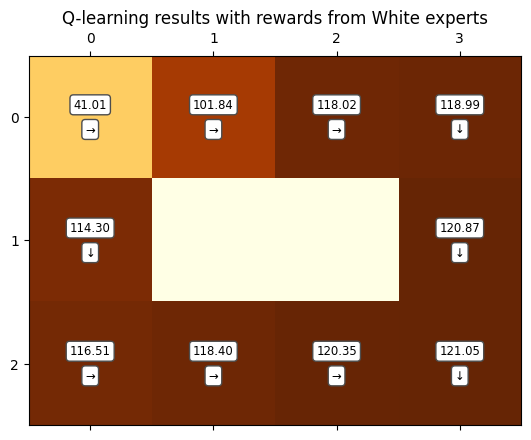

In [13]:
fig, ax = plt.subplots()
ax.matshow(data, cmap='YlOrBr')

for (i, j), z in np.ndenumerate(data):
    if z == 0:
        continue
    ax.text(j, i-0.1, 
            '{:0.2f}'.format(z), 
            ha='center', 
            va='center', 
            size='small',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
        )

for (i, j), z in np.ndenumerate(label):
    ax.text(j, i+0.1, 
            z,
            ha='center', 
            va='center', 
            size='small',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
        )

ax.set_title(f'Q-learning results with rewards from White experts')

plt.show()